# Random Sample

## 1. Exponential Distribution

1.  **自行實作** 指數分布的隨機數產生器（要能自訂發生的速率 λ ），**禁止使用 NumPy、SciPy 或其他模組內建的指數/泊松分布抽樣函數**。
2.  產生 1000 個指數分布的隨機數，並計算它們的**均值（mean）與變異數（variance）**，檢查是否接近理論值。
3.  **畫出直方圖**，觀察數據是否符合指數分布的形狀。
4.  提示：可以用 Inverse Transform Sampling。


## 2. 驗證 Exponential Distribution 與 Poisson Distribution 的關係

### 背景知識

Poisson Distribution 描述的是**固定時間內發生的事件數量**。而指數分布描述的是**事件之間的時間間隔**，如果事件是根據 Poisson Distribution 發生的，那麼**事件發生的間隔時間**服從 Exponential Distribution。換句話說，泊松分布與指數分布存在以下關係：

-   如果事件發生的時間間隔服從**指數分布**，那麼在單位時間內發生的事件數量就會服從**泊松分布**。
-   也就是說，如果我們產生很多**指數分布的隨機數**，並將它們累積起來，統計某段時間內發生的事件數量，那麼這些數據應該會符合泊松分布。

### 實驗設計

請按照以下步驟進行實驗，並驗證泊松分布與指數分布的關係：

1.  **使用內建函數（NumPy 或 SciPy）產生泊松分布與指數分布的隨機數：**
    -   產生 1000 個泊松分布的隨機數（使用 `numpy.random.poisson(λ, size)`）。
    -   產生 1000 個指數分布的隨機數（使用 `numpy.random.exponential(1/λ, size)`）。
2.  **驗證指數分布的間隔時間能夠模擬泊松分布：**
    -   產生 10000 個指數分布的隨機數，將這些數字看成是事件發生的間隔時間。
    -   透過累積間隔時間，計算在單位時間內發生的事件數，這些數據應該符合泊松分布。
    -   計算這些數據的均值與變異數，與泊松分布的理論值 E[X]=λ，Var(X)=λ 比較。
3.  **畫出直方圖，觀察分布形狀：**
    -   繪製泊松分布與指數分布的直方圖，檢查它們的形狀是否符合理論分布。
    -   繪製指數分布累積後得到的泊松分布直方圖，檢查其是否與內建的泊松分布相似。



---

## 模擬結果

[程式連結](https://github.com/AsherJingkongChen/random-sample/blob/main/random_sample.ipynb)


+-----------------------------------------+-------+--------+------------------+
|                                 subject |  size |   rate | [mean, variance] |
+=============================================================================+
| (theoretical) random_sample_exponential |     0 | 1.0000 | [1.0000, 1.0000] |
| (theoretical) random_sample_exponential |     0 | 2.0000 | [0.5000, 0.2500] |
| (theoretical) random_sample_exponential |     0 | 4.0000 | [0.2500, 0.0625] |
| (implemented) random_sample_exponential |  1000 | 1.0000 | [1.0123, 1.0005] |
| (implemented) random_sample_exponential |  1000 | 2.0000 | [0.5062, 0.2501] |
| (implemented) random_sample_exponential |  1000 | 4.0000 | [0.2531, 0.0625] |
|     (theoretical) random_sample_poisson |     0 | 1.0000 | [1.0000, 1.0000] |
|     (theoretical) random_sample_poisson |     0 | 2.0000 | [2.0000, 2.0000] |
|     (theoretical) random_sample_poisson |     0 | 4.0000 | [4.0000, 4.0000] |
|     (implemented) random_sample_poisso

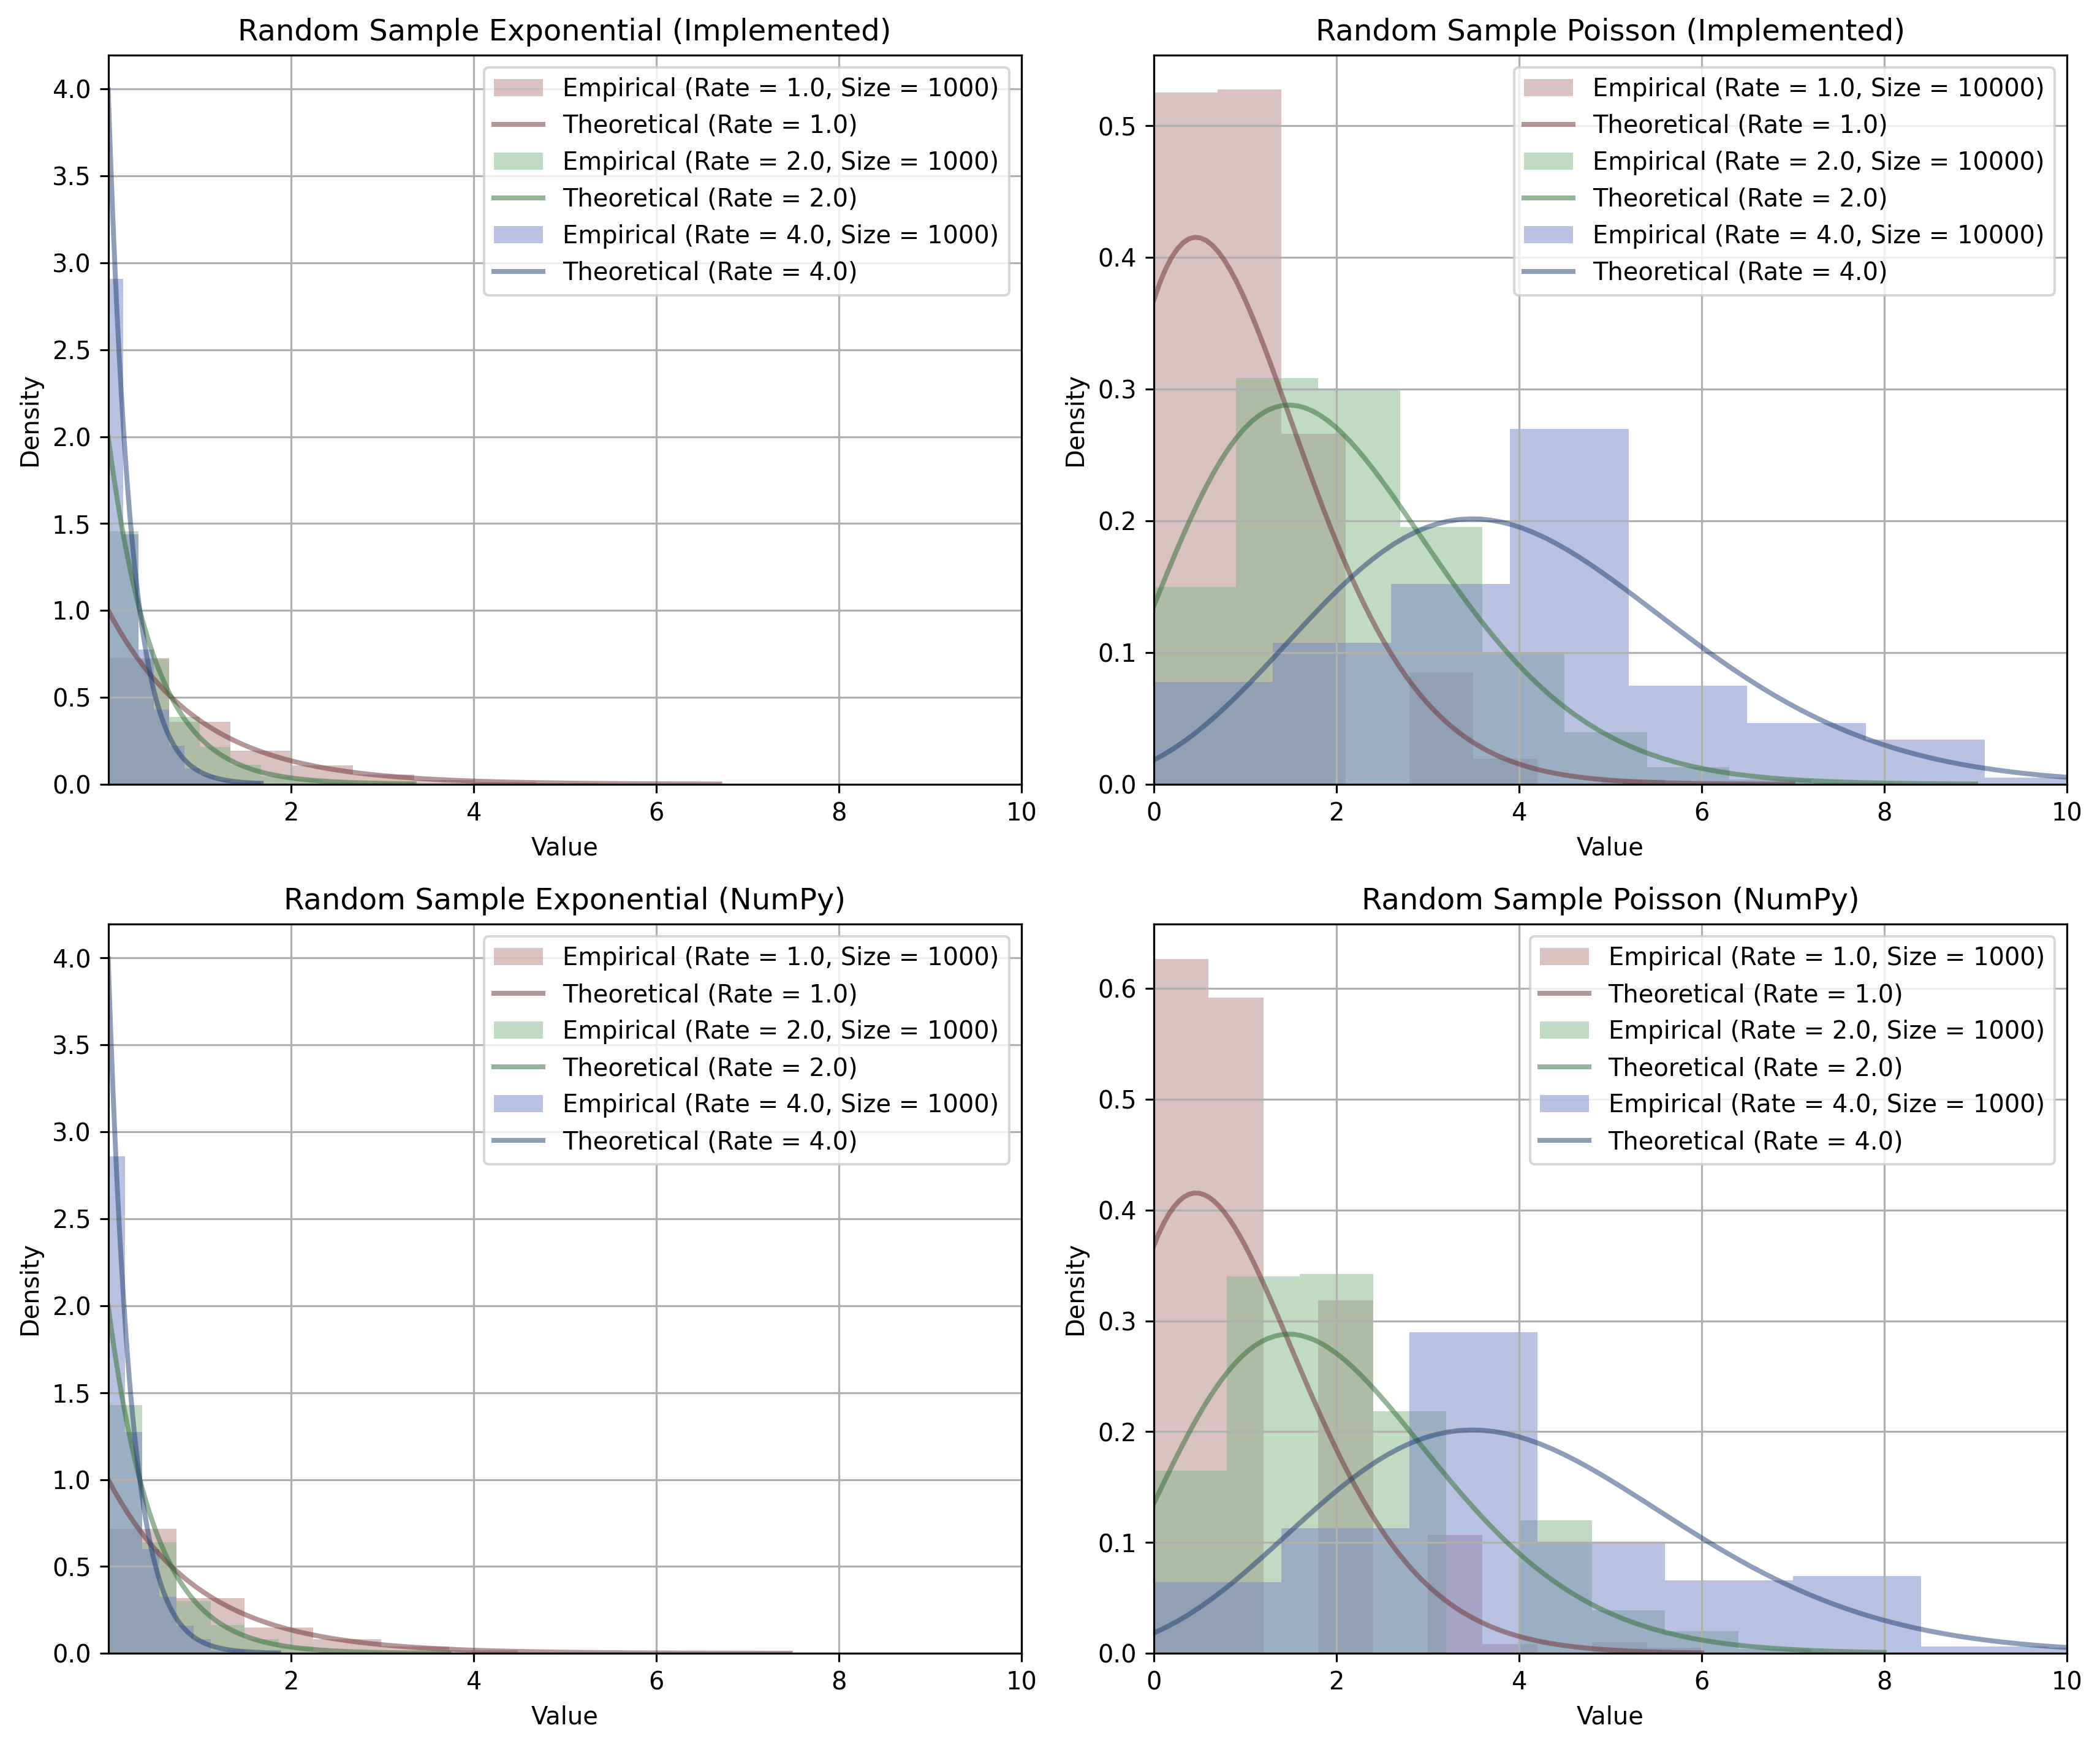

In [21]:
import math as mh
import numpy as np
import polars as pl

from cycler import cycler
from matplotlib import pyplot as plt
from numpy.typing import ArrayLike
from typing import Callable, Optional, Tuple


def build_stats(seq: ArrayLike) -> tuple[float, float]:
    return np.mean(seq), np.var(seq)


def random_sample_exponential(size: int, rate: float, seed: int) -> ArrayLike:
    uniform_samples = np.random.default_rng(seed).uniform(size=size)
    return -np.log(uniform_samples) / rate


def random_sample_exponential_numpy(size: int, rate: float, seed: int) -> ArrayLike:
    return np.random.default_rng(seed).exponential(1 / rate, size=size)


def random_sample_exponential_p(x: ArrayLike, rate: int) -> ArrayLike:
    return rate * np.exp(-rate * np.maximum(x, 0))


def random_sample_poisson(size: int, rate: float, seed: int) -> ArrayLike:
    t = np.cumsum(random_sample_exponential(size, rate, seed))
    return np.diff(np.searchsorted(t, np.arange(mh.ceil(t[-1])), "right"))


def random_sample_poisson_numpy(size: int, rate: float, seed: int) -> ArrayLike:
    return np.random.default_rng(seed).poisson(rate, size=size)


def random_sample_poisson_p(x: ArrayLike, rate: float) -> ArrayLike:
    x = np.asarray(x)
    return np.exp(x * np.log(rate) - rate - np.vectorize(mh.lgamma)(x + 1))


def draw_sample_histogram(
    *,
    axis: plt.Axes,
    empirical_data: ArrayLike,
    empirical_label: str = "Empirical",
    theoretical_data: Optional[Callable[[ArrayLike], ArrayLike]] = None,
    theoretical_label: str = "Theoretical",
) -> Tuple[plt.Figure, plt.Axes]:
    bins = axis.hist(
        empirical_data,
        alpha=0.5,
        bins=10,
        density=True,
        label=empirical_label,
    )[1]
    if theoretical_data is not None:
        theoretical_line_x = np.linspace(bins[0], bins[-1], len(bins) * 10)
        axis.plot(
            theoretical_line_x,
            theoretical_data(theoretical_line_x),
            alpha=0.5,
            label=theoretical_label,
            lw=2,
        )

    axis.set_xlabel("Value")
    axis.set_ylabel("Density")
    axis.set_xlim(bins[0], 10)
    axis.legend()
    axis.grid(True)
    return axis.figure, axis


if __name__ == "__main__":
    RATE_TEST_VALUES = [1.0, 2.0, 4.0]
    SEED = 42
    TABLE_SIZE_MAX = 120

    with pl.Config(
        ascii_tables=True,
        float_precision=4,
        fmt_str_lengths=TABLE_SIZE_MAX,
        tbl_cell_alignment="RIGHT",
        tbl_cols=TABLE_SIZE_MAX,
        tbl_hide_column_data_types=True,
        tbl_hide_dataframe_shape=True,
        tbl_rows=TABLE_SIZE_MAX,
        tbl_width_chars=TABLE_SIZE_MAX,
    ):
        print(
            pl.concat(
                [
                    pl.DataFrame(
                        {
                            "subject": "(theoretical) random_sample_exponential",
                            "size": 0,
                            "rate": RATE_TEST_VALUES,
                            "[mean, variance]": [
                                [1 / r, 1 / r**2] for r in RATE_TEST_VALUES
                            ],
                        }
                    ),
                    pl.DataFrame(
                        dict(
                            subject="(implemented) random_sample_exponential",
                            size=1000,
                            rate=RATE_TEST_VALUES,
                        )
                    ).with_columns(
                        pl.struct(["size", "rate"])
                        .map_elements(
                            lambda r: build_stats(
                                random_sample_exponential(
                                    size=r["size"],
                                    rate=r["rate"],
                                    seed=SEED,
                                )
                            ),
                            return_dtype=pl.List(pl.Float64),
                        )
                        .alias("[mean, variance]"),
                    ),
                    pl.DataFrame(
                        {
                            "subject": "(theoretical) random_sample_poisson",
                            "size": 0,
                            "rate": RATE_TEST_VALUES,
                            "[mean, variance]": [[r, r] for r in RATE_TEST_VALUES],
                        }
                    ),
                    pl.DataFrame(
                        dict(
                            subject="(implemented) random_sample_poisson",
                            size=10000,
                            rate=RATE_TEST_VALUES,
                        )
                    ).with_columns(
                        pl.struct(["size", "rate"])
                        .map_elements(
                            lambda r: build_stats(
                                random_sample_poisson(
                                    size=r["size"],
                                    rate=r["rate"],
                                    seed=SEED,
                                )
                            ),
                            return_dtype=pl.List(pl.Float64),
                        )
                        .alias("[mean, variance]"),
                    ),
                ]
            )
        )

    with plt.rc_context(
        {
            "axes.prop_cycle": cycler(
                color=[
                    "#B68587",
                    "#6D2E32",
                    "#85B687",
                    "#2E6D32",
                    "#7586C7",
                    "#1E3D72",
                ],
            ),
        }
    ):
        axes = plt.subplots(2, 2, dpi=288, figsize=(12, 10))[1]

        axis = axes[0, 0]
        axis.set_title("Random Sample Exponential (Implemented)")
        size = 1000
        for rate in RATE_TEST_VALUES:
            draw_sample_histogram(
                axis=axis,
                empirical_data=random_sample_exponential(
                    size=size, rate=rate, seed=SEED
                ),
                empirical_label=f"Empirical (Rate = {rate}, Size = {size})",
                theoretical_label=f"Theoretical (Rate = {rate})",
                theoretical_data=lambda x: random_sample_exponential_p(x, rate),
            )

        axis = axes[0, 1]
        axis.set_title("Random Sample Poisson (Implemented)")
        size = 10000
        for rate in RATE_TEST_VALUES:
            draw_sample_histogram(
                axis=axis,
                empirical_data=random_sample_poisson(size=size, rate=rate, seed=SEED),
                empirical_label=f"Empirical (Rate = {rate}, Size = {size})",
                theoretical_label=f"Theoretical (Rate = {rate})",
                theoretical_data=lambda x: random_sample_poisson_p(x, rate),
            )

        axis = axes[1, 0]
        axis.set_title("Random Sample Exponential (NumPy)")
        size = 1000
        for rate in RATE_TEST_VALUES:
            draw_sample_histogram(
                axis=axis,
                empirical_data=random_sample_exponential_numpy(
                    size=size, rate=rate, seed=SEED
                ),
                empirical_label=f"Empirical (Rate = {rate}, Size = {size})",
                theoretical_label=f"Theoretical (Rate = {rate})",
                theoretical_data=lambda x: random_sample_exponential_p(x, rate),
            )

        axis = axes[1, 1]
        axis.set_title("Random Sample Poisson (NumPy)")
        size = 1000
        for rate in RATE_TEST_VALUES:
            draw_sample_histogram(
                axis=axis,
                empirical_data=random_sample_poisson_numpy(
                    size=size, rate=rate, seed=SEED
                ),
                empirical_label=f"Empirical (Rate = {rate}, Size = {size})",
                theoretical_label=f"Theoretical (Rate = {rate})",
                theoretical_data=lambda x: random_sample_poisson_p(x, rate),
            )

        plt.tight_layout()
        plt.show()


---

## 結論

### 1. Exponential Distribution

-   自行實作採樣的隨機數符合指數分佈，其平均數與變異數接近指數分佈的理論值。
    -   例如當速率 $\lambda = 2$ 時，採樣 $1000$ 個隨機數的平均數約為 $0.5062$，與理論值 $0.5$ 的相對誤差約為 $0.0124$（符合理論）；變異數約為 $0.2501$，與理論值 $0.25$ 的相對誤差約為 $0.0004$（符合理論）。如圖 $\text{Random Sample Exponential (Implemented)}$ 中所示，經驗分佈函式 $\text{Empirical (Rate = 2, Size = 1000)}$ 也接近機率密度函式 $\text{Theoretical (Rate = 2)}$ 的形狀（符合理論）。

### 2. 驗證 Exponential Distribution 與 Poisson Distribution 的關係

-   自行實作採樣的隨機數符合指數分佈，經過累積後，計算在單位時間內發生的事件數，其平均數與變異數接近泊松分佈的理論值。
    -   例如當速率 $\lambda = 4$ 時，採樣 $10000$ 個隨機數的平均數約為 $3.9753$，與理論值 $4$ 的相對誤差約為 $0.0062$（符合理論）；變異數約為 $4.0328$，與理論值 $4$ 的相對誤差約為 $0.0082$（符合理論）。如圖 $\text{Random Sample Poisson (Implemented)}$ 中所示，經驗分佈函式 $\text{Empirical (Rate = 4, Size = 10000)}$ 也接近機率質量函式 $\text{Theoretical (Rate = 4)}$ 的形狀（符合理論）。
-   觀察 $\text{numpy.random}$ 實作採樣的隨機數（符合指數分佈或泊松分佈），其形狀皆接近理論值，也接近自行實作的模組之結果。
    -   如圖 $\text{Random Sample Exponential (NumPy)}$ 與圖 $\text{Random Sample Poisson (NumPy)}$ 所示。


In [22]:
%%html
<style>
    .jp-Cell.jp-Notebook-cell:nth-last-child(3) .jp-Cell-inputArea,
    .jp-Cell.jp-Notebook-cell:last-child {
        display: none;
    }

    @page {
        size: A4 portrait;
        margin: 5mm 0 !important;
    }

    :root {
        --jp-content-link-color: dodgerblue;
    }

    a code {
        color: var(--jp-content-link-color) !important;
    }

    body {
        margin: 0 !important;
    }

    code,
    pre {
        font-family: Monaco, monospace !important;
        font-size: 10px !important;
        font-weight: 400 !important;
        line-height: 1.35 !important;
    }

    img {
        max-width: 80% !important;
    }

    h1 {
        text-align: center !important;
    }

    h1,
    h2,
    h3,
    h4,
    h5,
    h6,
    strong {
        font-weight: 700 !important;
    }

    h1,
    hr {
        page-break-before: always;
    }

    hr {
        visibility: hidden;
    }

    pre {
        white-space: pre-wrap;
    }

    table,
    td,
    th,
    tr,
    tbody,
    thead,
    tfoot {
        page-break-inside: avoid !important;
    }

    .jp-RenderedHTMLCommon {
        font-family: Calibri, Verdana, sans-serif !important;
        font-size: 12px !important;
        font-weight: 400 !important;
        line-height: 1.35 !important;
    }

    .jp-RenderedHTMLCommon td,
    .jp-RenderedHTMLCommon th,
    .jp-RenderedHTMLCommon tr {
        border: 1px solid var(--md-grey-500);
    }

    .jp-RenderedHTMLCommon table {
        margin-left: 2em;
    }

    .jp-CodeCell {
        margin-bottom: 1.5em;
    }
</style>